<a href="https://colab.research.google.com/github/fabiobasson/Bi-Master/blob/main/geological_comparative_create_14102021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project:** Posgraduate Business Intelligence Master PUC-RJ 2021

# **Classification and Prediction of rock images in drilled wells via Learning Methods Supervised by geological classification of images**

# **1. Overview of files**

**geological_similarity/: stores the images of the 6 types of rocks: **   

* andesite/:rock images directory andesite;
*   gneiss/:rock images directory gneiss;
*   marble:rock images directory marble;
*   quartzite:rock images directory quartzite;
*   rhyolite:rock images directory rhyolite
*   schist:drock images directory schist;

    
Este trabalho se concentrará na análise ....

In [ ]:
# Import from libraries

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer

from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import np_utils
from PIL import Image
import plotly.express as px
import cv2 as cv
from imutils import paths
import matplotlib.pyplot as plt


from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import hamming_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split

In [ ]:
# Checking Tensorflow and Keras Versions
print(tf.__version__)

# Install Tensorflow
#!pip install tensorflow==2.6.0

# Install Keras
!pip install keras --upgrade

2.6.0


In [ ]:
# If necessary, remove the directories

#!rm -rf geological_similarity andesite gneiss/ marble/ quartzite/ rhyolite/ schist/
#!rm -rf geological_similarity


# **2. Extraction, Transformation and Loading of the Data**

## **2.1. Kaglle Data Collection**

In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.

#!kaggle datasets download fabiobasson/geologicalsimilarity
#! unzip -qq  geologicalsimilarity
!kaggle datasets download tanyadayanand/geological-image-similarity
! unzip -qq geological-image-similarity   

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/.kaggle/kaggle.': No such file or directory
 80% 27.0M/33.6M [00:00<00:00, 48.6MB/s]
100% 33.6M/33.6M [00:00<00:00, 84.9MB/s]


# **Creating the directory structure**

In [ ]:
andesite_dir = glob.glob('geological_similarity/andesite/*.jpg');gneiss_dir = glob.glob('geological_similarity/gneiss/*.jpg')
marble_dir= glob.glob('geological_similarity/marble/*.jpg');quartzite_dir = glob.glob('geological_similarity/quartzite/*.jpg')
rhyolite_dir = glob.glob('geological_similarity/rhyolite/*.jpg');
schist_dir = glob.glob('geological_similarity/schist/*.jpg')
print(len(andesite_dir));print(len(gneiss_dir)); print(len(marble_dir)); print(len(quartzite_dir));  print(len(quartzite_dir)); print(len(schist_dir))

andesite_df=[];gneiss_df=[];marble_df=[];quartzite_df=[];rhyolite_df=[];schist_df=[]

label1=['andesite','gneiss','marble','quartzite','rhyolite','schist']

for i in andesite_dir:
    andesite_df.append([i,label1[0]])
for j in gneiss_dir:
   gneiss_df.append([j,label1[1]])
for l in marble_dir:
    marble_df.append([l,label1[2]])
for m in quartzite_dir:
    quartzite_df.append([m,label1[3]])
for n in rhyolite_dir:
    rhyolite_df.append([n,label1[4]])
for o in schist_dir:
    schist_df.append([o,label1[5]])
   
df = andesite_df + gneiss_df + marble_df  + quartzite_df + rhyolite_df + schist_df
random.shuffle(df)
len(df)


5000
5000
4998
5000
5000
5000


29998

# **Creation of Parameters**

In [ ]:
INIT_LR = 1e-3
EPOCHS = 200
BS=24

# **Dataframe Creation**

In [ ]:
# Criação do Dataframe
data_df = pd.DataFrame(df,columns=['path','label'])
data_df

,path,label
0,geological_similarity/gneiss/EZE57.jpg,gneiss
1,geological_similarity/marble/9DSXA.jpg,marble
2,geological_similarity/andesite/44B5P.jpg,andesite
3,geological_similarity/quartzite/3USE5.jpg,quartzite
4,geological_similarity/quartzite/GXFLG.jpg,quartzite
...,...,...
29993,geological_similarity/marble/GEI7B.jpg,marble
29994,geological_similarity/gneiss/I1TJ9.jpg,gneiss
29995,geological_similarity/schist/FY35G.jpg,schist
29996,geological_similarity/rhyolite/UL42T.jpg,rhyolite


# **Convert the images to 32 by 32**

In [ ]:
dados=[]
labels=[]

for imagePath in data_df['path']:

      label = imagePath.split(os.path.sep)[-2]

      image = cv.imread(imagePath)
      image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
      image = cv.resize(image, (32, 32))
      
      dados.append(image)
      labels.append(label)
      
print("labels: ", np.unique(labels))

# Convert data and labels to NumPy arrays while scaling the pixel
dados = np.array(dados) 
labels = np.array(labels)
labels

labels:  ['andesite' 'gneiss' 'marble' 'quartzite' 'rhyolite' 'schist']


array(['gneiss', 'marble', 'andesite', ..., 'schist', 'rhyolite',
       'gneiss'], dtype='<U9')

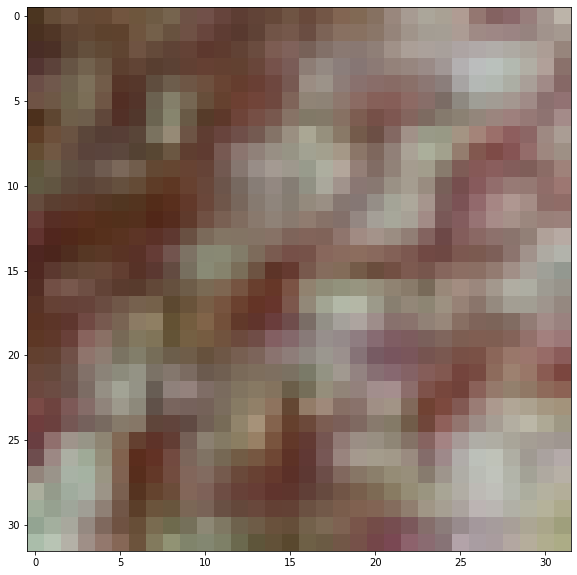

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(dados[labels=='marble'][5])
plt.show()

# **Renaming labels from string format to int**

In [ ]:
lb={'andesite':[1, 0, 0, 0, 0, 0] ,'gneiss':[0, 1, 0, 0, 0, 0] ,'marble':[0, 0, 1, 0, 0, 0], 'quartzite':[0, 0, 0, 1, 0, 0], 'rhyolite':[0, 0, 0, 0, 1, 0], 'schist':[0, 0, 0, 0, 0, 1]}
len(labels)

labels1 = [lb[label] for label in labels]
labels1 = np.array(labels1)
print(labels1)

[[0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [1 0 0 0 0 0]
 ...
 [0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [0 1 0 0 0 0]]


# **Creating the Dataframe on Training, Validation and Testing Data**

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(dados, labels1, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train,test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(17998, 32, 32, 3)
(17998, 6)
(6000, 32, 32, 3)
(6000, 6)
(6000, 32, 32, 3)
(6000, 6)


# **Normalization**

In [ ]:
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

# **Knowing Image Data**

In [ ]:
from numpy import asarray
image = Image.open("geological_similarity/gneiss/0QTQE.jpg")
# Método asarray para realizar a conversão:
pixels= asarray(image)
# Verificando a faixa de valores entre 0 e 255:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

#Converte os valores inteiros em float para realizar a operação:
pixels = pixels.astype('float32')
# Normaliza a faixa de valores:
pixels /= pixels.max()
# Verificando a faixa de valores normalizada:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Data Type: uint8
Min: 32.000, Max: 251.000
Data Type: float32
Min: 0.127, Max: 1.000


# **Data cleaning**
1 - Analyzing missing data
2 - Discarding missing data
3 - Imputing data
4 - Adding informative columns

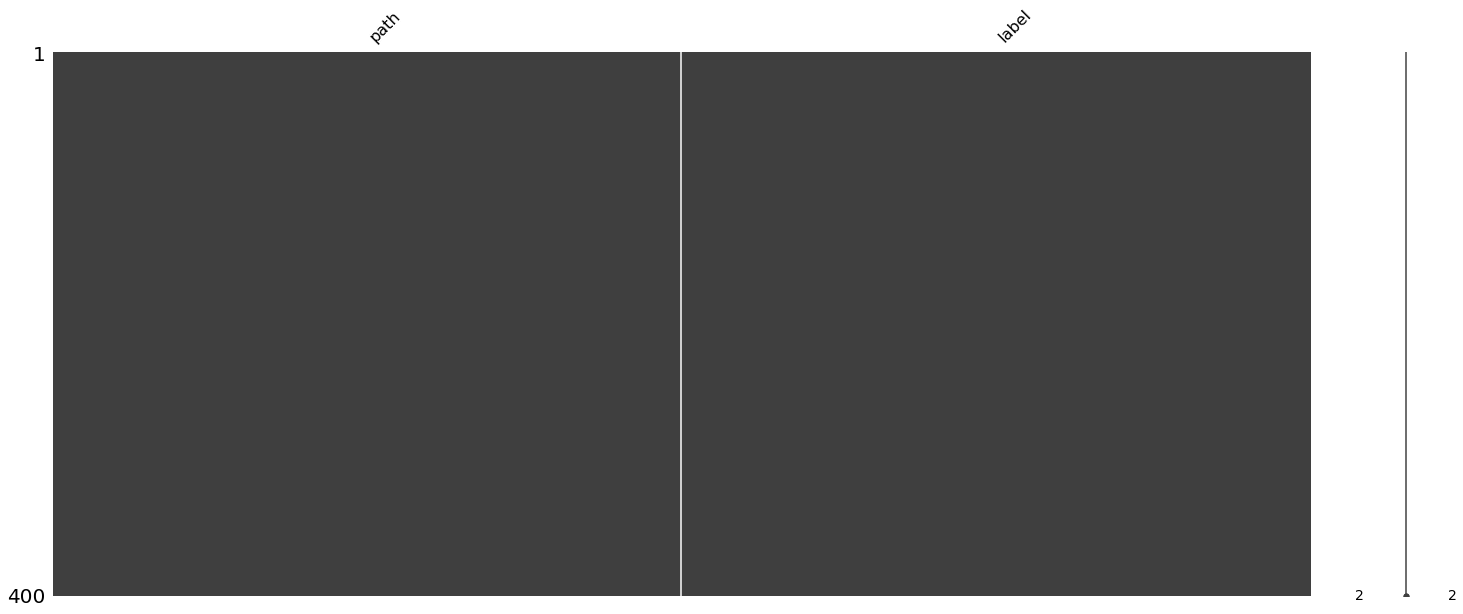

In [ ]:
### 1 - Analyzing missing ###

import missingno as msno
ax = msno.matrix(data_df.sample(400))

# **Exploring the data**


# **Type: Data Augumentation**

## ** This function will plot the images in a 1 to 5 column grid **

In [ ]:
IMG_SHAPE = 32

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
# Creating the Training and Validation data

datagen = ImageDataGenerator(rescale=1./255,
                            #featurewise_center =False ,
                            # samplewise_center =False ,
                            # featurewise_std_normalization =False ,
                            # samplewise_std_normalization =False ,
                            # zca_whitening =False ,
                            # zca_epsilon =1e -6 ,
                            # channel_shift_range =0. ,
                            # fill_mode = ’ nearest ’ ,
                            # cval =0. ,
                            rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split=0.2)

datagen_val = ImageDataGenerator (rescale=1./255, 
                                 validation_split=0.2)

In [ ]:
train_generator = datagen.flow_from_dataframe (data_df,
    batch_size=BS,
    x_col='path',
    y_col= 'label',
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='categorical',
    subset='training')

validation_generator = datagen_val.flow_from_dataframe (data_df,
    batch_size=BS,
    x_col='path',
    y_col= 'label',
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='categorical',
    subset='validation')

Found 23999 validated image filenames belonging to 6 classes.
Found 5999 validated image filenames belonging to 6 classes.


In [ ]:
# Test Data

datagen_test = ImageDataGenerator (rescale=1./255, 
                                   #validation_split=0.8,
                                  rotation_range = 40)

test_generator = datagen_test.flow_from_dataframe(data_df,
                                                   batch_size=1,
                                                   x_col='path',
                                                   y_col='label',
                                                   shuffle=False,
                                                   target_size=(IMG_SHAPE,IMG_SHAPE),
                                                   class_mode='categorical')
                                                   #subset='validation')

Found 29998 validated image filenames belonging to 6 classes.


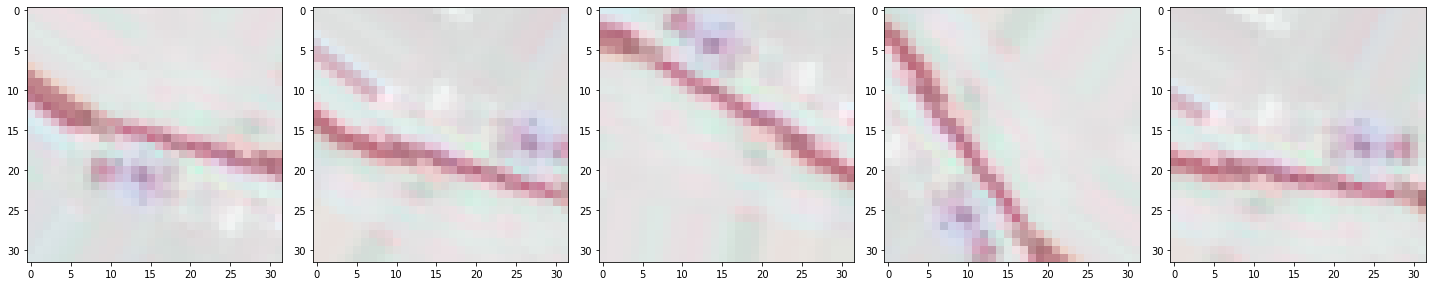

In [ ]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
class_dict=test_generator.class_indices
labels= test_generator.labels
file_names= test_generator.filenames 

test_generator.class_indices.keys()

#X_test, y_test = next(test_generator) # não utilizado

dict_keys(['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist'])

# **Create the Model**

In [ ]:
num_classes = 6

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
   
])


# **The summary of the Conv2D model built.**

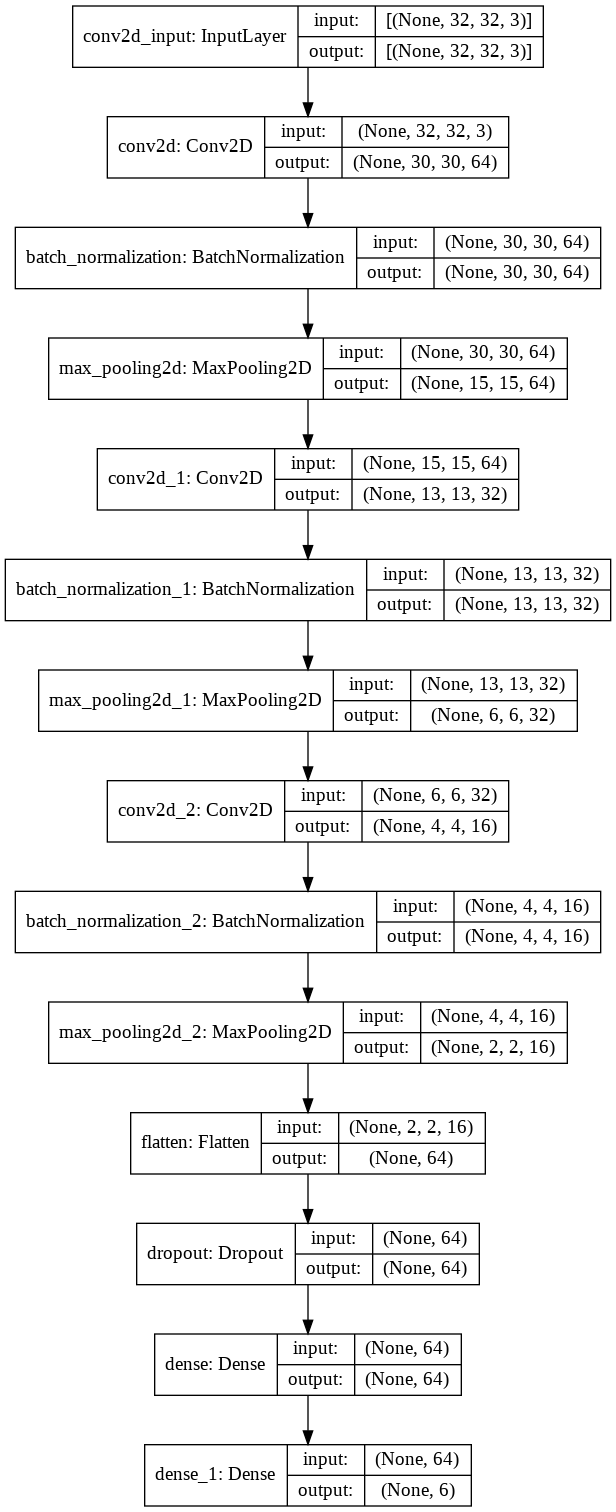

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

# **Compiling the Model**

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])
model.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 16)          4

In [ ]:
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        #save_weights_only=False,
        mode='max',
        #period=1,
    ),

]

## ** **Model training**
At this stage, the models are exposed to the exams and their outputs are compared to the notes taken by the physicians, as a way of ascertaining the difference in the prediction and adjusting the network parameters on top of the identified error, in order to make it more suitable for future iterations .



In [ ]:
# Time (25/10/2021)

history = model.fit(X_train,y_train,
                               batch_size=BS,
                               epochs=EPOCHS,
                               verbose=1,
                               callbacks=callbacks_list,
                               steps_per_epoch = len(X_train)//BS, 
                               #validation_split=0.2,
                               #class_weight=class_weight_,
                               workers=4,
                               use_multiprocessing=True,
                               validation_steps = len(X_val)//BS,
                               validation_data= (X_val,y_val))

Epoch 1/200
749/749 [==============================] - 48s 63ms/step - loss: 0.9270 - accuracy: 0.6669 - val_loss: 0.3261 - val_accuracy: 0.8923

Epoch 00001: val_accuracy improved from -inf to 0.89233, saving model to best_model.h5
Epoch 2/200
749/749 [==============================] - 46s 62ms/step - loss: 0.3979 - accuracy: 0.8606 - val_loss: 0.1771 - val_accuracy: 0.9420

Epoch 00002: val_accuracy improved from 0.89233 to 0.94200, saving model to best_model.h5
Epoch 3/200
749/749 [==============================] - 46s 62ms/step - loss: 0.2952 - accuracy: 0.8984 - val_loss: 0.3022 - val_accuracy: 0.8932

Epoch 00003: val_accuracy did not improve from 0.94200
Epoch 4/200
749/749 [==============================] - 46s 62ms/step - loss: 0.2422 - accuracy: 0.9177 - val_loss: 0.2398 - val_accuracy: 0.9078

Epoch 00004: val_accuracy did not improve from 0.94200
Epoch 5/200
749/749 [==============================] - 46s 62ms/step - loss: 0.2193 - accuracy: 0.9255 - val_loss: 0.2100 - val_a

Text(0.5, 1.0, 'Train - Accuracy')

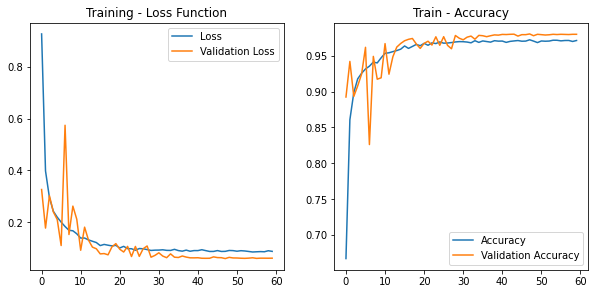

In [ ]:
# Let us graph Training Accuracy vs. Loss to get a better understanding of model training.
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')


# **Let's plot the training and validation accuracy as well as the loss.** 

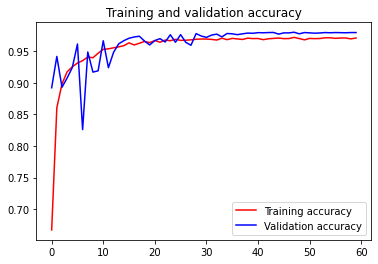

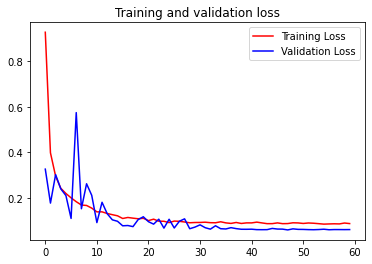

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **Evaluate Model Accuracy**

In [ ]:
# (ref http://stackoverflow.com/q/32239577/395857)

def hamming_score(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [ ]:
print("Conv2D - resultados")

model = tf.keras.models.load_model("best_model.h5")

y_pred = model.predict(X_test)

test_loss, test_acc= model.evaluate(X_test,y_test)
print("validation_accuracy: " + str(test_acc))
print("-------\n")

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")
print("-------\n")

#Em tal situação, a perda de Hamming é uma boa medida do desempenho do modelo. 
#Diminuir a perda de Hamming, melhor o desempenho do modelo.
#Para os rótulos acima, a perda de Hamming é de 0,XXX, conforme calculado abaixo.

hs = hamming_score(y_test, y_pred)
print(f"Hamming loss: {hs}")
print("-------\n")

Conv2D - resultados
188/188 [==============================] - 4s 18ms/step - loss: 0.0605 - accuracy: 0.9770
validation_accuracy: 0.9769999980926514
-------

Test accuracy: 0.9769999980926514
Test loss: 0.06050073355436325
-------

Hamming loss: 0.16666666666666666
-------



# **Perform predictions for classes with the created model**

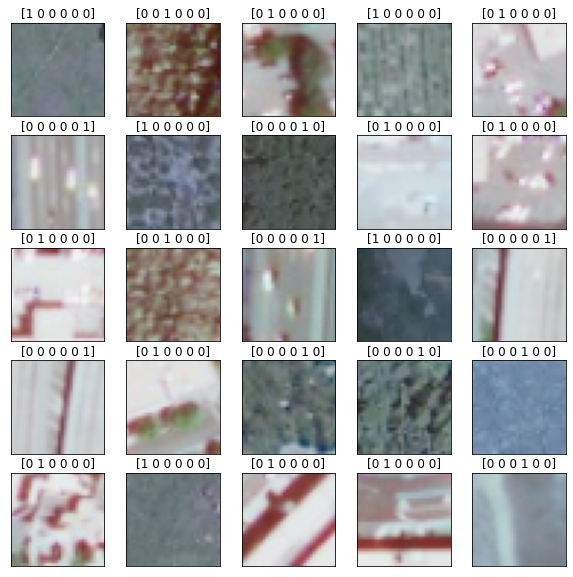

In [ ]:
class_names = ['andesite','gneiss','marbler','quartzite','rhyolite','schist']
#class_names = [0,1,2,3,4,5]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.title(y_train[i])
    #plt.xlabel(y_train[i])
plt.show()
   

# **Performing predictions and confirmations**

In [ ]:
y_pred = model.predict(X_test)
print("Prediction_accuracy: " + str(y_pred))

Prediction_accuracy: [[2.8117819e-04 8.0172014e-01 3.2005388e-05 2.0445627e-03 6.0437120e-05
  1.9586168e-01]
 [9.8579895e-01 1.7793938e-05 2.3932430e-06 1.3947262e-02 1.5517803e-04
  7.8505371e-05]
 [1.5511404e-04 1.9677002e-06 1.0435218e-08 9.9983501e-01 3.5424714e-06
  4.2745814e-06]
 ...
 [3.6466963e-07 2.8977986e-06 9.9999619e-01 3.8766547e-08 5.0753027e-07
  1.3776453e-07]
 [1.6917753e-04 1.5165286e-05 8.8883262e-08 9.9979097e-01 6.7992710e-06
  1.7878261e-05]
 [2.0671458e-05 1.6202907e-08 9.2843908e-07 4.6720700e-07 9.9997795e-01
  1.5149221e-08]]


In [ ]:
y_pred[400] #  400 position prediction

array([6.7653396e-08, 8.5778424e-07, 9.9999893e-01, 5.8314500e-09,
       1.3915108e-07, 3.8170217e-08], dtype=float32)

In [ ]:
print(np.argmax(y_pred[400])) # In this case, the prediction is pointed out - Class 4

2


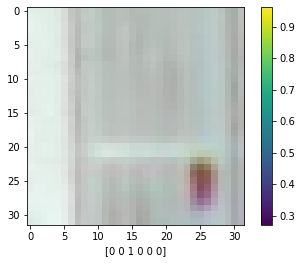

In [ ]:
# In this case, the prediction is correct - Class 4, as shown below:
plt.figure()
plt.imshow(X_train[400])
plt.xlabel(y_test[400])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
y_pred[305] # first prediction position 1

array([1.1290940e-06, 1.0116497e-05, 9.9998629e-01, 1.5931229e-07,
       7.8922903e-07, 1.5898546e-06], dtype=float32)

In [ ]:
np.argmax(y_pred[305]) # In this case, the prediction is correct - Class 01

2

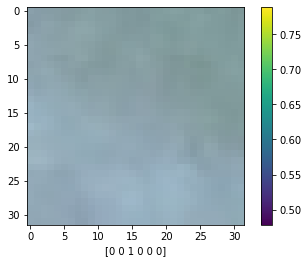

In [ ]:
# In this case, the prediction is correct - Class 01, as shown in the figure below:
plt.figure()
plt.imshow(X_train[305])
plt.xlabel(y_test[305])
plt.colorbar()
plt.grid(False)
plt.show()

# ** Prediction for a single image.**

In [ ]:
img = X_test [50]
test_labels_single = y_test [50]
print(img.shape)

test_labels_single

# Adiciona a imagem em um batch que possui um só membro.
img = (np.expand_dims(img,0))

print(img.shape)

(32, 32, 3)
(1, 32, 32, 3)


In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

predictions_single = np.argmax(predictions_single, axis=1)
predictions_single

[[2.6547093e-07 1.6901386e-05 4.3178501e-09 1.4573754e-07 4.3700774e-07
  9.9998224e-01]]


array([5])

# **Classification report**
We can summarize the performance of our classifier as follows:

In [ ]:
# Make predictions on the test set
print("[INFO] evaluating network...")
y_pred = model.predict(X_test,batch_size=BS)

# For each image in the test set, we need to find the index of the
# label with the corresponding highest predicted probability
y_pred = np.argmax(y_pred, axis=1)

# Shows a well-formatted ranking report
print(classification_report(y_test.argmax(axis=1), y_pred,target_names=lb))

#Get the indices to be plotted
#y_true = 
#correct = np.nonzero(y_pred==y_true)[0]
#incorrect = np.nonzero(y_pred!=y_true)[0]
#from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]
#print(classification_report(y_true, y_pred, target_names=target_names))'''

[INFO] evaluating network...
              precision    recall  f1-score   support

    andesite       0.96      0.95      0.96       987
      gneiss       0.97      0.99      0.98      1026
      marble       1.00      1.00      1.00       979
   quartzite       0.97      0.97      0.97       989
    rhyolite       0.97      0.99      0.98       978
      schist       0.99      0.96      0.98      1041

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



# **the confusion matrix**

[[ 940    0    0   23   24    0]
 [   0 1013    0    2    0   11]
 [   0    0  979    0    0    0]
 [  24    1    0  961    2    1]
 [  11    0    0    0  967    0]
 [   0   32    0    5    2 1002]]


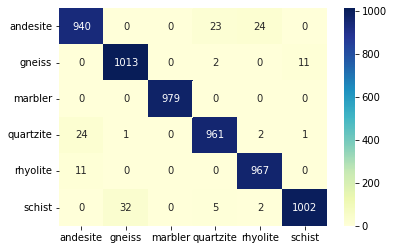

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.argmax(axis=1),y_pred)

# show the confusion matrix
print(cm)

cm_matrix = pd.DataFrame(data=cm, columns=['andesite','gneiss','marbler','quartzite','rhyolite','schist'], 
                                 index=['andesite','gneiss','marbler','quartzite','rhyolite','schist'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# Calculate the confusion matrix and use it to derive the
# precision, sensitivity and specificitye

total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# Show accuracy, sensitivity and specificity
print("acc: {:.4f}".format(acc))

acc: 0.3255


In [ ]:
true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

scratch_preds = modelvgg16.predict(test_generator)
scratch_pred_classes = np.argmax(scratch_preds, axis=1)

vgg_preds = modelvgg16.predict(test_generator)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [ ]:
# Get the names of the ten classes
class_names1 = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names1, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names1, 
        yticklabels=class_names1,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

#fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))

plot_heatmap(true_classes, scratch_pred_classes, class_names1, ax1, title="Custom ")    
#plot_heatmap(true_classes, vgg_pred_classes, class_names1, ax2, title="Transfer Learning (VGG16)")    
#plot_heatmap(true_classes, vgg_pred_classes_ft, class_names1, ax3, title="Transfer Learning (VGG16) with Fine-Tuning") 

In [ ]:
#Get the predictions for the test data
predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)

L = 3
W = 3
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"Prediction Class = {predicted_classes[i]}\n   Original Class = {y_test[i]}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

# **Save the Model Create**

In [ ]:
file = open('model', 'wb')
pickle.dump(model, file)

# **Comparação: modelo Criado vs  modelo pre treinado VGG16**

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
acc = [test_acc,test_accvgg16]
model = ['Modelo Criado','Modelo pre treinado VGG16']
#model = ['Modelo Criado','VGG16','InceptionV3','EfficientNetB0','EfficientNetB7']
ax.bar(model,acc)
plt.show()